#### Implement text classification using word2vec and LSTM

In [103]:
import numpy as np 
import pandas as pd 


In [104]:
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam



In [105]:
data=pd.read_csv('../Dataset/IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [106]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [107]:
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [108]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
import nltk
nltk.download('omw-1.4')
stop_words = set(stopwords.words("english"))
lemmatizer=WordNetLemmatizer()

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/vicky_gupta/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [109]:
def preprocessing(x):
    # replacing
    x=x.replace('<br />', '').replace('\n', '').replace('\'', '')
    # Convert to lower case
    x=x.lower() 
    # Remove special characters
    x=re.sub("[^a-zA-Z]"," ",x) 
    # Split the sentence into words
    x=x.split() 
    # Lemmatize the words and remove the stopwords
    x=[lemmatizer.lemmatize(word) for word in x if word not in stop_words]
    # Join the words
    x=" ".join(x)
    return x

In [110]:
data['review'] = data['review'].apply(preprocessing)

In [111]:
data['review'][1]

'wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done'

In [112]:
data.head()

,review,sentiment
0,one reviewer mentioned watching oz episode you...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically there family little boy jake think t...,negative
4,petter matteis love time money visually stunni...,positive


In [113]:
reviews = data['review'].values
labels = data['sentiment'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(reviews, encoded_labels,test_size = 0.25)

In [115]:
X_train.shape, X_test.shape

((37500,), (12500,))

In [116]:
vocab_size = 3000
oov_tok = ''
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'


In [117]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [118]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train, padding='post', maxlen=max_length)

In [119]:
X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, padding='post', maxlen=max_length)

In [120]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Bidirectional(LSTM(128)))
#model.add(LSTM(128))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          300000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 551009 (2.10 MB)
Trainable params: 551009 (2.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [121]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [122]:
history = model.fit(X_train_padded, y_train, epochs=5, verbose=1,steps_per_epoch = len(X_train)/256,batch_size = 256,validation_split=0.1)

Epoch 1/5
146/146 [==============================] - 73s 491ms/step - loss: 0.4637 - accuracy: 0.7736 - val_loss: 0.3283 - val_accuracy: 0.8680
Epoch 2/5
146/146 [==============================] - 79s 541ms/step - loss: 0.2785 - accuracy: 0.8894 - val_loss: 0.3425 - val_accuracy: 0.8691
Epoch 3/5
146/146 [==============================] - 83s 568ms/step - loss: 0.2493 - accuracy: 0.9054 - val_loss: 0.3402 - val_accuracy: 0.8648
Epoch 4/5
146/146 [==============================] - 87s 597ms/step - loss: 0.2274 - accuracy: 0.9112 - val_loss: 0.3437 - val_accuracy: 0.8669
Epoch 5/5
146/146 [==============================] - 43s 295ms/step - loss: 0.2212 - accuracy: 0.9137 - val_loss: 0.3576 - val_accuracy: 0.8669


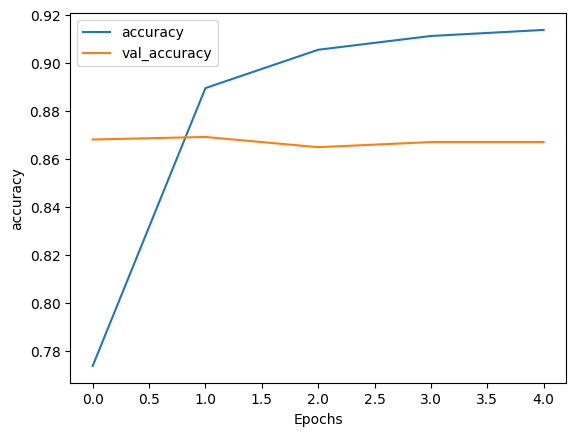

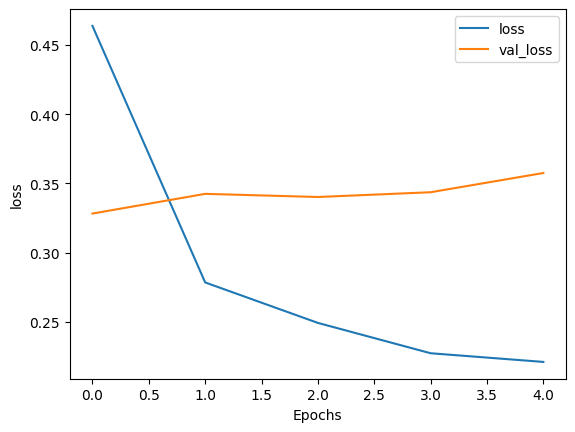

In [123]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [124]:
from sklearn.metrics import accuracy_score
prediction = model.predict(X_test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
y_pred = []
for i in prediction:
    if i >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(y_test,y_pred))

391/391 [==============================] - 23s 58ms/step
Accuracy of prediction on test set :  0.87648


In [128]:
print(X_test_padded[0])
check=["The movie was a great waste of time. The story was not good and the acting was bad. I would not recommend this movie to anyone."]
check = tokenizer.texts_to_sequences(check)
check_padded = pad_sequences(check, padding='post', maxlen=max_length)
print(model.predict(check_padded))

[   5    2 2193 1448    1    1    4  360    4    1   37   49    1 1894
    1    7  320  112   40    2    1    1   27 2748 2193 1448 1781   11
    1 1796 2666 2193 1448  199  360    2   23    1   55   35    1    1
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 